
# Week 4

## Part 1. Regular Expressions

> * Now, explain in your own words: what are regular expressions?

            A regular expression is a pattern-matching language used for finding substrings models in a main string.

> * Provide an example of a regex to match 4 digits numbers (by this, I mean precisely 4 digits, you should not match any part of numbers with e.g. 5 digits). In your notebook, use `findall` to show that your regex works on this [test-text](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/regex_exercise.txt). **Hint**: a great place to test out regular expressions is: https://regex101.com.

In [14]:
import re
import requests

# Get the string from the address https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/regex_exercise.txt
URL = "https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/regex_exercise.txt"
string = requests.get(URL).text

# Find all the 4 digit numbers in the string
match_4_numbers = re.findall(r'\b\d{4}\b', string)

if(match_4_numbers):
    for m in match_4_numbers:
        print(m)
else:
    print("No matches found")

1234
9999


> * Provide an example of a regex to match words starting with "super". Show that it works on the [test-text](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/regex_exercise.txt).



In [15]:
match_super = re.findall(r'\bsuper\w*', string)

if(match_super):
    for m in match_super:
        print(m)
else:
    print("No matches found")

superpolaroid
supertaxidermy
superbeer


Finally, we need to figure out how how to match internal wiki links. Wiki links come in two flavors. They're always enclosed in double square brackets, e.g. `[[wiki-link]]` and can either occur like this:

    ... some text [[Aristotle]] some more text ...

which links to the page [`https://en.wikipedia.org/wiki/Aristotle`](https://en.wikipedia.org/wiki/Aristotle). 

The second flavor has two parts, so that links can handle spaces and other more fancy forms of references, here's an example:

    ... some text [[John_McCain|John McCain]] some more text ...

which links to the page [`https://en.wikipedia.org/wiki/John_McCain`](https://en.wikipedia.org/wiki/Eudemus_of_Rhodes). Now it's your turn.

> _Exercise_: Regular expressions round 2\. Show that you can extract the wiki-links from the [test-text](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/regex_exercise.txt). Perhaps you can find inspiration on stack overflow or similar. **Hint**: Try to solve this exercise on your own (that's what you will get the most out of - learning wise), but if you get stuck ... you will find the solution in one of the video lectures below.
> 

In [16]:
wiki_links = re.findall(r'\[\[.*?\]\]', string)

if(wiki_links):
    for m in wiki_links:
        print(m)
else:
    print("No matches found")

[[drinking vinegar]]
[[gentrify]]
[[hashtag]]
[[Bicycle|Bicycle(two-wheeled type)]]
[[Pitchfork|Pitchfork Magazine]]


## Part 2. Building the network

> The overall strategy for this is the following: 
> Take the pages you have downloaded for each rappers. 
> Each page corresponds to a rapper, which is a node in your network. 
> Find all the hyperlinks in a rapper's page that link to another node of the network (e.g. an other character). 
> There are many ways to do this, but below, I've tried to break it down into natural steps. 
> Keep in mind that the network should include **both** West-coast and East-coast rappers (and that it is possible that some West-coast rappers will have links to East-coast rappers and vice-versa).
> 
> **Note**: When you add a node to the network, also include an `attribute` (i.e. that specifies the universe where the character comes from; either West coast, or East coast)
>
>
> * Use a regular expression to extract all outgoing links from each of the pages you downloaded above. 
> * For each link you extract, check if the target is a rapper. If yes, keep it. If no, discard it.
> * Use a NetworkX [`DiGraph`](https://networkx.github.io/documentation/development/reference/classes.digraph.html) to store the network. Store also the properties of the nodes (i.e. which coast they represent).
> * When have you finished, you'll notice that some nodes do not have any out- or in- degrees. You may *discard* those from the network.

In [17]:
import pandas as pd
import networkx as nx


G = nx.DiGraph()

# Read the csv file with the rapper names in the west and east coast
EastCoastRappers = pd.read_csv("../files/EastCoastRappers.csv")
WestCoastRappers = pd.read_csv("../files/WestCoastRappers.csv")

# Create the file for the rappers that are in both lists
f_both = open("../files/BothCoastRappers.csv", "w")
f_both.write(",WikipediaPageName\n")

# Check if there are any rappers that are in both lists
new_index = 0
for index, row in EastCoastRappers.iterrows():
    for index2, row2 in WestCoastRappers.iterrows():
        if (row['WikipediaPageName'] == row2['WikipediaPageName']):
            f_both.write(str(new_index) + "," + row['WikipediaPageName'] + "\n")
            # Remove the rapper from the west and east coast list
            WestCoastRappers.drop(index2, inplace=True)
            EastCoastRappers.drop(index, inplace=True)
            new_index += 1
            break

BothCoastRappers = pd.read_csv("../files/BothCoastRappers.csv")
            

# Add nodes to the graph
for index, row in EastCoastRappers.iterrows():
    G.add_node(row['WikipediaPageName'], region='EastCoast')

for index, row in WestCoastRappers.iterrows():
    G.add_node(row['WikipediaPageName'], region='WestCoast')

for index, row in BothCoastRappers.iterrows():
    G.add_node(row['WikipediaPageName'], region='BothCoast')

# Setup wikipedia requests
WIKI_REQUEST_URL = "https://en.wikipedia.org/w/api.php?"
params = {
    'action': 'query',
    'format': 'json',
    'prop': 'links',
    'pllimit': 'max',
    'titles': ''
}

# Add edges to the graph 
# It should have an edge between two rappers if their wikipedia pages link to each other
for index, row in EastCoastRappers.iterrows():
    params['titles'] = row['WikipediaPageName']
    request = requests.get(WIKI_REQUEST_URL, params=params).json().get('query').get('pages').popitem()[1].get('links')
    for link in request:
        if (link['title'] in G.nodes()):
            G.add_edge(row['WikipediaPageName'], link['title'])

for index, row in WestCoastRappers.iterrows():
    params['titles'] = row['WikipediaPageName']
    request = requests.get(WIKI_REQUEST_URL, params=params).json().get('query').get('pages').popitem()[1].get('links')
    for link in request:
        if (link['title'] in G.nodes()):
            G.add_edge(row['WikipediaPageName'], link['title'])

for index, row in BothCoastRappers.iterrows():
    params['titles'] = row['WikipediaPageName']
    request = requests.get(WIKI_REQUEST_URL, params=params).json().get('query').get('pages').popitem()[1].get('links')
    for link in request:
        if (link['title'] in G.nodes()):
            G.add_edge(row['WikipediaPageName'], link['title'])





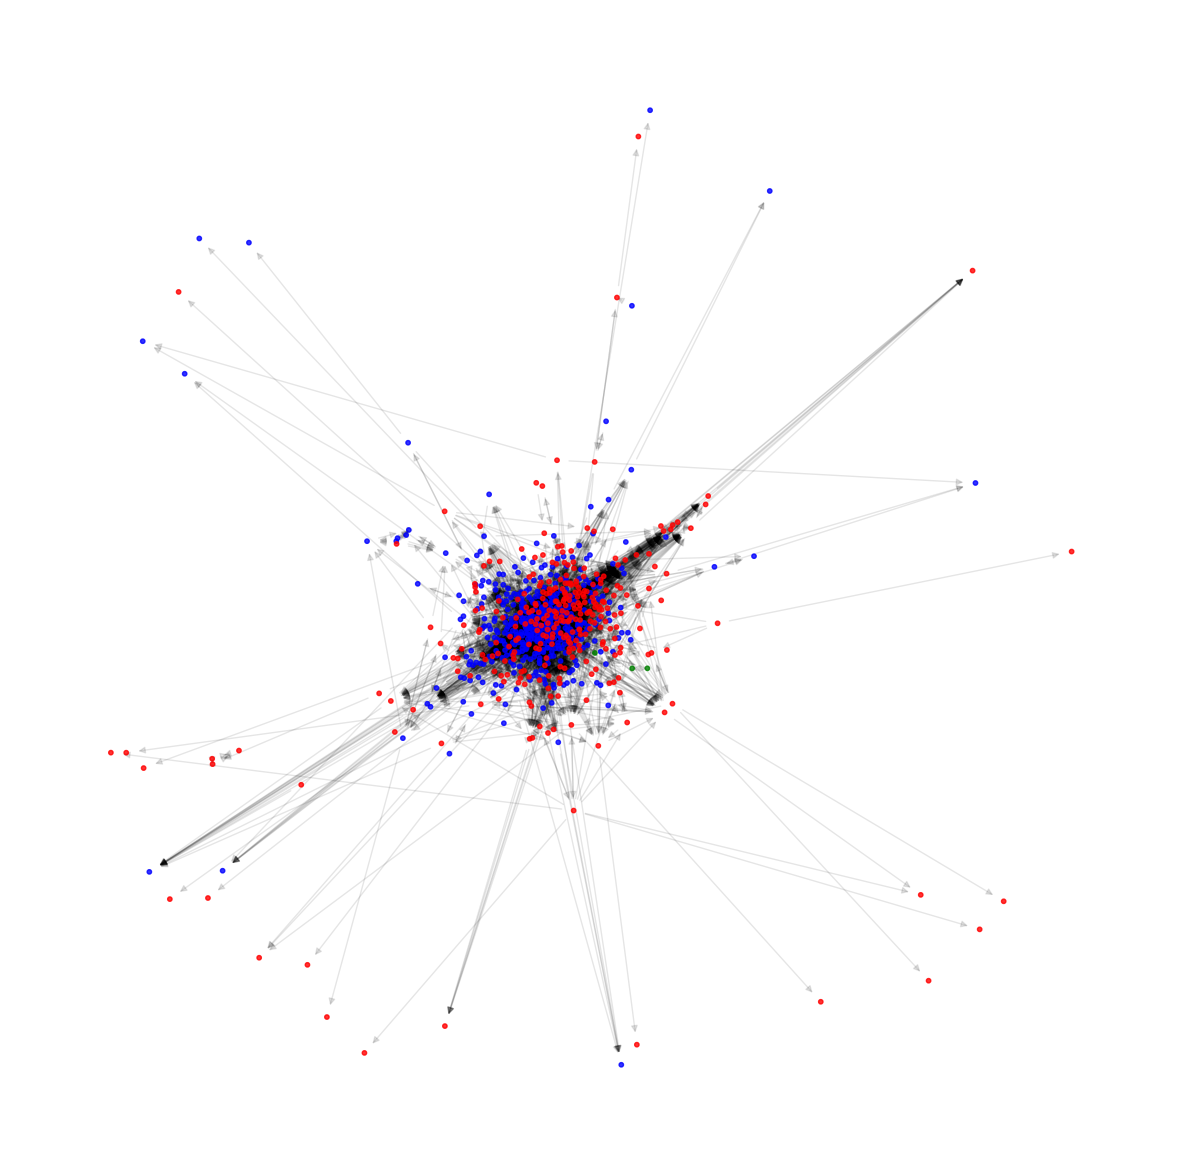

In [18]:
# Display the graph (only the largest connected component)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

pos = nx.spring_layout(G, k=0.05)

# Remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))

# Color nodes according to their region
node_colors = []
for node in G.nodes():
    if(G.nodes[node]['region'] == 'EastCoast'):
        node_colors.append('blue')
    elif(G.nodes[node]['region'] == 'WestCoast'):
        node_colors.append('red')
    else:
        node_colors.append('green')

nx.draw_networkx_nodes(G, pos, node_size=10, node_color=node_colors, alpha=0.8)

nx.draw_networkx_edges(G, pos, alpha=0.1)

plt.axis('off')

plt.draw()

> * What is the number of nodes in the network? 









In [19]:
nb_nodes = G.number_of_nodes()
nb_nodes

729

> * More importantly, what is the number of links?

In [20]:
nb_edges = G.number_of_edges()
nb_edges

5909

> * What is the number of links connecting West coast and East coast? What do those links mean?

In [21]:
# Compute the number of edges crossing from one region to another
crossing_edges = 0
for edge in G.edges():
    if ((G.nodes[edge[0]]['region'] == "WestCoast" and G.nodes[edge[1]]['region'] == "EastCoast") or 
       (G.nodes[edge[0]]['region'] == "EastCoast" and G.nodes[edge[1]]['region'] == "WestCoast")
       ):
        crossing_edges += 1
crossing_edges

1331

> * Plot the in and out-degree distributions. What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?

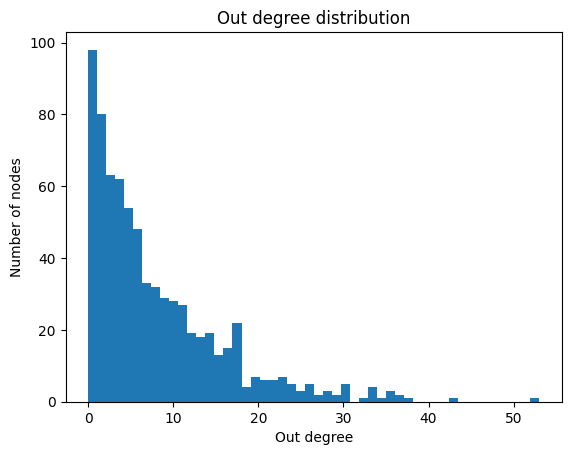

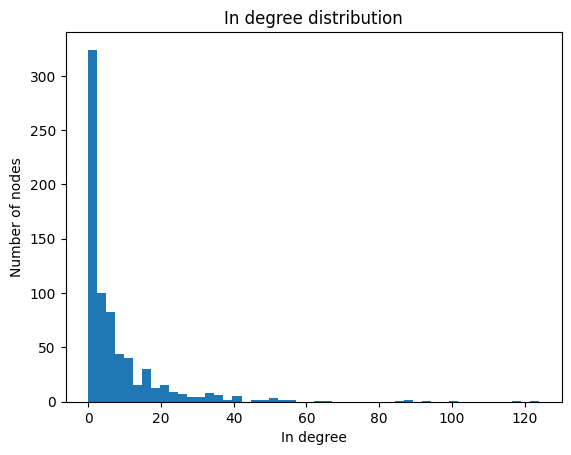

In [22]:
# Out degree distribution

out_degrees = [G.out_degree(n) for n in G.nodes()]
plt.hist(out_degrees, bins=50)
plt.title("Out degree distribution")
plt.xlabel("Out degree")
plt.ylabel("Number of nodes")
plt.show()

# In degree distribution

in_degrees = [G.in_degree(n) for n in G.nodes()]
plt.hist(in_degrees, bins=50)
plt.title("In degree distribution")
plt.xlabel("In degree")
plt.ylabel("Number of nodes")
plt.show()


>     * Compare the degree distribution to a *random network* with the same number of nodes and *p*

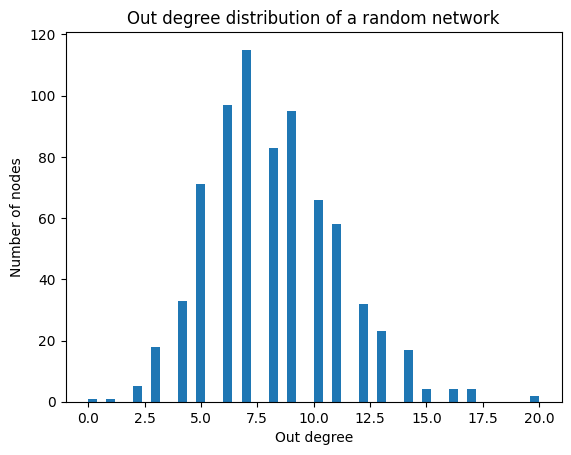

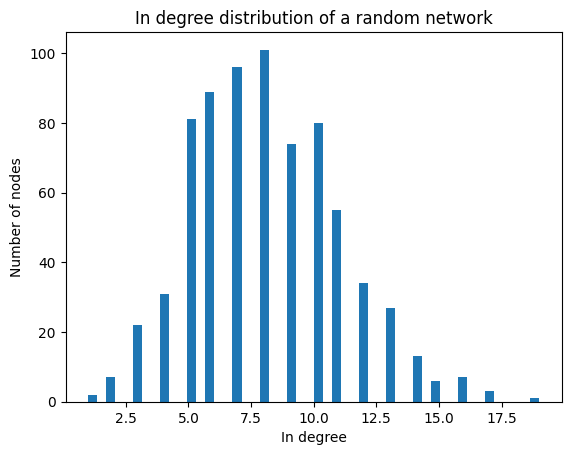

In [23]:
# Degree distribution of a random network with the same number of nodes and edges

random_graph = nx.gnm_random_graph(nb_nodes, nb_edges, directed=True)

random_out_degrees = [random_graph.out_degree(n) for n in random_graph.nodes()]
plt.hist(random_out_degrees, bins=50)
plt.title("Out degree distribution of a random network")
plt.xlabel("Out degree")
plt.ylabel("Number of nodes")
plt.show()

random_in_degrees = [random_graph.in_degree(n) for n in random_graph.nodes()]
plt.hist(random_in_degrees, bins=50)
plt.title("In degree distribution of a random network")
plt.xlabel("In degree")
plt.ylabel("Number of nodes")
plt.show()



>     * Compare the degree distribution to a *scale-free* network with the same number of nodes.

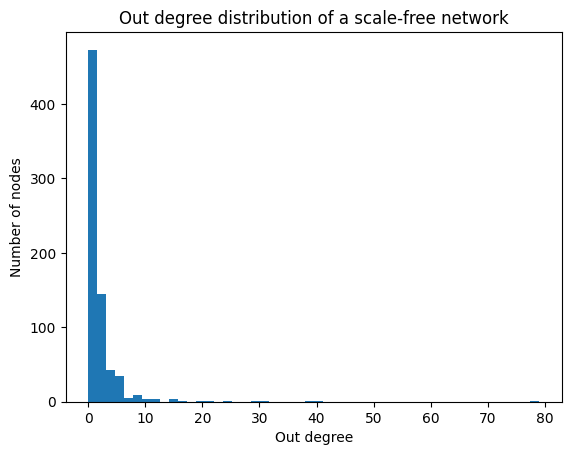

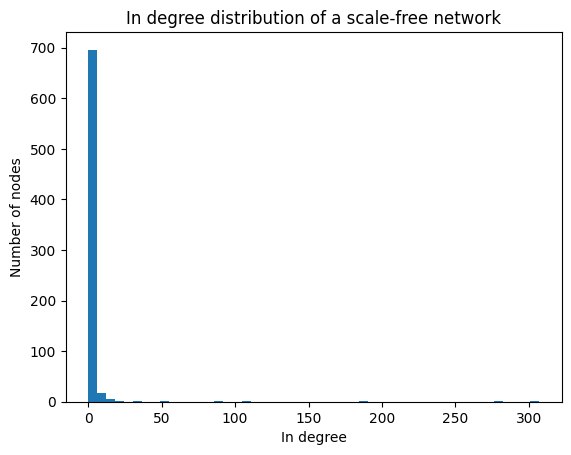

In [24]:
# Degree distribution of a scale-free network with the same number of nodes and edges

scale_free_graph = nx.scale_free_graph(nb_nodes, alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0, create_using=None, seed=None)

scale_free_out_degrees = [scale_free_graph.out_degree(n) for n in scale_free_graph.nodes()]
plt.hist(scale_free_out_degrees, bins=50)
plt.title("Out degree distribution of a scale-free network")
plt.xlabel("Out degree")
plt.ylabel("Number of nodes")
plt.show()

scale_free_in_degrees = [scale_free_graph.in_degree(n) for n in scale_free_graph.nodes()]
plt.hist(scale_free_in_degrees, bins=50)
plt.title("In degree distribution of a scale-free network")
plt.xlabel("In degree")
plt.ylabel("Number of nodes")
plt.show()



> * Who are top 10 most connected rappers? (Report results for in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [25]:
# Search of the 10 most connected rappers (in and out degree rankings)

# In degree
in_degree_ranking = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)

print("In degree ranking:")

for i in range(10):
    print(in_degree_ranking[i])


# Out degree
out_degree_ranking = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)

print()
print("Out degree ranking:")

for i in range(10):
    print(out_degree_ranking[i])

In degree ranking:
('Jay-Z', 124)
('Snoop Dogg', 119)
('50 Cent', 100)
('Nas', 94)
('Dr. Dre', 88)
('Busta Rhymes', 87)
('Kendrick Lamar', 85)
('Tupac Shakur', 65)
('The Notorious B.I.G.', 62)
('Wiz Khalifa', 57)

Out degree ranking:
('Drag-On', 53)
('Black Thought', 43)
('DJ Dahi', 38)
('The Game (rapper)', 37)
('Kurupt', 37)
('Jahlil Beats', 35)
('MC Lyte', 35)
('Nas', 35)
('DJ Premier', 34)
('French Montana', 33)


> * Who are the top 5 most connected West coast rappers (again in terms of both in/out-degree)?

In [26]:
# Search of the 5 most connected west coast rappers (in and out degree rankings)

# In degree
print()
print("In degree ranking:")

nb = 0
i = 0
while(nb != 5):
    if(G.nodes[in_degree_ranking[i][0]]['region'] in {"WestCoast", "BothCoast"}):
        print(nb+1, in_degree_ranking[i])
        nb += 1
    i += 1

# Out degree
print()
print("Out degree ranking:")

nb = 0
i = 0
while(nb != 5):
    if(G.nodes[out_degree_ranking[i][0]]['region'] in {"WestCoast", "BothCoast"}):
        print(nb+1, out_degree_ranking[i])
        nb += 1
    i += 1






In degree ranking:
1 ('Snoop Dogg', 119)
2 ('Dr. Dre', 88)
3 ('Kendrick Lamar', 85)
4 ('Tupac Shakur', 65)
5 ('The Game (rapper)', 53)

Out degree ranking:
1 ('DJ Dahi', 38)
2 ('The Game (rapper)', 37)
3 ('Kurupt', 37)
4 ('The Alchemist (musician)', 33)
5 ('Kam (rapper)', 33)


> * Who are the top 5 most connected East coast rappers (again in terms of both in/out-degree)?

In [27]:
# Search of the 5 most connected west coast rappers (in and out degree rankings)

# In degree
print()
print("In degree ranking:")

nb = 0
i = 0
while(nb != 5):
    if(G.nodes[in_degree_ranking[i][0]]['region'] in {"EastCoast", "BothCoast"} ):
        print(nb+1, in_degree_ranking[i])
        nb += 1
    i += 1

# Out degree
print()
print("Out degree ranking:")

nb = 0
i = 0
while(nb != 5):
    if(G.nodes[out_degree_ranking[i][0]]['region'] in {"EastCoast", "BothCoast"} ):
        print(nb+1, out_degree_ranking[i])
        nb += 1
    i += 1



In degree ranking:
1 ('Jay-Z', 124)
2 ('50 Cent', 100)
3 ('Nas', 94)
4 ('Busta Rhymes', 87)
5 ('The Notorious B.I.G.', 62)

Out degree ranking:
1 ('Drag-On', 53)
2 ('Black Thought', 43)
3 ('Jahlil Beats', 35)
4 ('MC Lyte', 35)
5 ('Nas', 35)
